In [1]:
import pandas as pd
from tqdm import tqdm
import os
import librosa as lb
import numpy as np
import seaborn as sns
import numpy as np
from glob import glob
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
#import splitfolders
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Input, MaxPooling1D, Activation, Permute, Dense, BatchNormalization, Flatten, LSTM, Bidirectional, Dropout, Masking, TimeDistributed

Using TensorFlow backend.


In [2]:
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
...,...,...,...,...,...,...
6852,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav,1.972
6853,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav,1.843
6854,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav,1.957
6855,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav,1.943


In [4]:
#define LSTM model with skip connection
def LSTM():
    N_CLASSES=4

    i = layers.Input(shape=(20, 79), name='input')
    x = layers.Masking()(i)
    x = layers.BatchNormalization(name='batch_norm')(x)
    x = layers.Permute((2,1), name='permute')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.5, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=regularizers.l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [5]:
LSTM().summary()

Model: "long_short_term_memory"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 20, 79)]     0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 20, 79)       0           input[0][0]                      
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 20, 79)       316         masking[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 79, 20)       0           batch_norm[0][0]                 
_____________________________________________________________________________

In [6]:
# Split data into train and test sets
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=0)

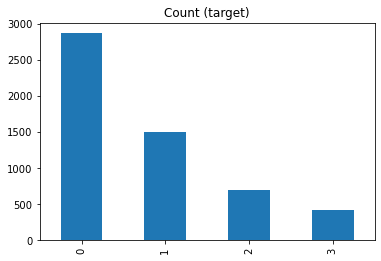

In [7]:
train_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

In [8]:
train_df

,fname,start,end,crack_wheez,fname_cycle,len
6349,213_1p3_Al_mc_AKGC417L,18.306,19.174,0,213_1p3_Al_mc_AKGC417L_6.wav,0.868
1551,133_2p2_Ar_mc_AKGC417L,0.137,2.554,0,133_2p2_Ar_mc_AKGC417L_0.wav,2.417
415,109_1b1_Pr_sc_Litt3200,21.131,22.752,0,109_1b1_Pr_sc_Litt3200_11.wav,1.621
4135,172_2b5_Tc_mc_AKGC417L,15.634,18.840,2,172_2b5_Tc_mc_AKGC417L_5.wav,3.206
4784,184_1b1_Ar_sc_Meditron,17.779,19.979,0,184_1b1_Ar_sc_Meditron_7.wav,2.200
...,...,...,...,...,...,...
4931,186_3b3_Al_mc_AKGC417L,4.958,8.542,0,186_3b3_Al_mc_AKGC417L_1.wav,3.584
3264,158_2p3_Lr_mc_AKGC417L,9.975,11.544,1,158_2p3_Lr_mc_AKGC417L_6.wav,1.569
1653,133_2p4_Tc_mc_AKGC417L,8.375,10.780,0,133_2p4_Tc_mc_AKGC417L_3.wav,2.405
2607,151_3p2_Ar_mc_AKGC417L,7.488,10.860,1,151_3p2_Ar_mc_AKGC417L_2.wav,3.372


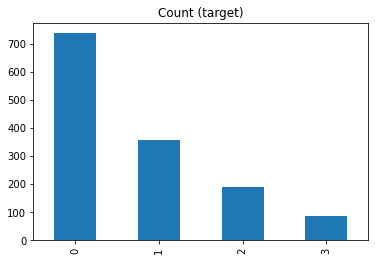

In [9]:
test_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

In [10]:
#Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
#Set maxpad length as 79 <--(Sampling rate*5s)/256(hop length)
def build_feat(df):
    X = []
    Y = []
    max_pad_len = 79
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez
        wav,  rate = lb.load('Breath_cycles/'+ file, sr=None)
        #limit the length of samples to only 6s (6*4000)
        if wav.shape[0] > 20000:
            wav = wav[0:20000]
        X_sample = lb.feature.mfcc(wav, sr=rate, n_fft=512,  win_length=400, n_mfcc=20, hop_length = 256, n_mels = 128, fmin = 100, fmax = 1800)
        pad_width = max_pad_len - X_sample.shape[1]
        X_sample = np.pad(X_sample, pad_width=((0, 0), (0, pad_width)), mode='constant')
        X.append(X_sample)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [12]:
#Extract features for training data
X_, y_ = build_feat(train_df)

100%|██████████| 5485/5485 [00:31<00:00, 175.72it/s]


In [13]:
X_.shape

(5485, 20, 79)

In [14]:
#Extract feature for testing data
X_val, y_val = build_feat(test_df)

100%|██████████| 1372/1372 [00:07<00:00, 177.26it/s]


In [15]:
np.save('X_', X_)
np.save('y_', y_)
np.save('X_val', X_val)
np.save('y_val', y_val)

In [16]:
X_ = np.load('X_.npy')
y_ = np.load('y_.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

In [17]:
#Convert labels into one hot vectors
y_tr_cat= to_categorical(y_, num_classes=4)
y_val_cat= to_categorical(y_val, num_classes=4)

In [18]:
csv_path = os.path.join('logs', 'log_history_5s.csv')
model = LSTM()
#Save model checkpoints
cp = ModelCheckpoint('models/lstm_5s.h5', monitor='val_accuracy',  save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
csv_logger = CSVLogger(csv_path, append=False)


In [19]:
#Fit model
model.fit(X_,y_tr_cat, epochs = 100, workers=4, batch_size = 64, validation_data=(X_val, y_val_cat), callbacks=[csv_logger, cp], verbose = True)


Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 1.1693 - accuracy: 0.5134
Epoch 00001: val_accuracy improved from -inf to 0.53717, saving model to models/lstm_5s.h5
86/86 [==============================] - 16s 190ms/step - loss: 1.1693 - accuracy: 0.5134 - val_loss: 1.1209 - val_accuracy: 0.5372
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.5262
Epoch 00002: val_accuracy improved from 0.53717 to 0.54082, saving model to models/lstm_5s.h5
86/86 [==============================] - 15s 174ms/step - loss: 1.1234 - accuracy: 0.5262 - val_loss: 1.0838 - val_accuracy: 0.5408
Epoch 3/100
86/86 [==============================] - ETA: 0s - loss: 1.0998 - accuracy: 0.5371
Epoch 00003: val_accuracy improved from 0.54082 to 0.55394, saving model to models/lstm_5s.h5
86/86 [==============================] - 15s 176ms/step - loss: 1.0998 - accuracy: 0.5371 - val_loss: 1.0859 - val_accuracy: 0.5539
Epoch 4/100
86/86 [=====================

In [20]:
# It can be used to reconstruct the model identically.
saved_model = keras.models.load_model("models/lstm_5s.h5")

                precision    recall  f1-score   support

          None       0.80      0.85      0.82       737
       Crackle       0.71      0.68      0.69       358
        Wheeze       0.58      0.48      0.53       189
Crackle_wheeze       0.55      0.59      0.57        88

      accuracy                           0.74      1372
     macro avg       0.66      0.65      0.65      1372
  weighted avg       0.73      0.74      0.73      1372



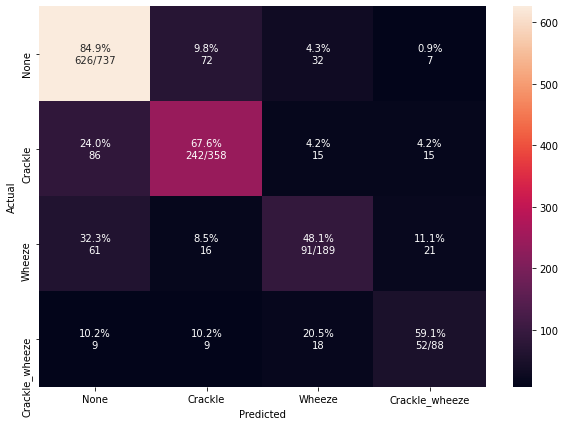

In [21]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = saved_model.predict(X_val)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_val_cat, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

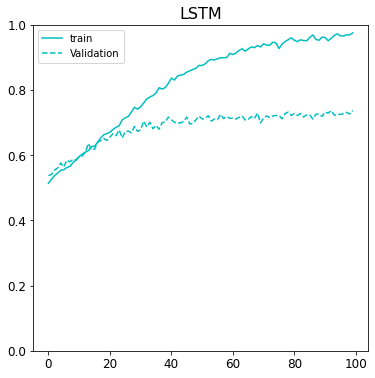

In [22]:
plt.figure(figsize=(6,6))
df = pd.read_csv('logs/log_history_5s.csv')
plt.title('LSTM', size=16)
plt.plot(df.accuracy, color='c', label='train')
plt.plot(df.val_accuracy, ls='--', color='c', label='Validation')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.0])
plt.show()